In [65]:
import cv2
import matplotlib.pyplot as plt

In [11]:
import argparse
from torch.utils.data import Dataset, DataLoader, sampler
import pandas as pd
import os
import numpy as np
from pathlib import Path
import torch
from tqdm.auto import tqdm
import torchvision.transforms.functional as TFF
import torchvision.transforms as TF
from PIL import Image
import torchvision.models
import torch.nn as nn
import pretrainedmodels as ptm
import wandb
import sklearn.metrics
import segmentation_models_pytorch as smp
import imgaug.augmenters as iaa
from imgaug.augmentables.segmaps import SegmentationMapsOnImage

/mnt/tank/scratch/tpolevaya/miniconda3/envs/main36/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [30]:
def read_image(pt, size, is_image=True):
    img = Image.open(pt)
    H,W, = np.array(img).shape[:2]
    img2 = TFF.center_crop(img, min(H,W))
    interp_mode = Image.BILINEAR if is_image else Image.NEAREST
    img3 = TFF.resize(img2, size, interpolation=interp_mode)
#     return img3
    arr = np.array(img3)
    return arr

def show(arr):
    if arr.max() == 1:
        arr *= 255
    arr = arr.astype(np.uint8)
    return Image.fromarray(arr)

In [4]:
ATTRIBUTES = ['globules', 'milia_like_cyst', 'negative_network', 'pigment_network', 'streaks']

In [20]:
# ID = 'ISIC_0013414'
ID = 'ISIC_0000000'
masks = {
    attr: read_image(f'images/ISIC2018_Task2_Training_GroundTruth_v3/{ID}_attribute_{attr}.png', 384, False)
    for attr in ATTRIBUTES
}

In [92]:
ID = 'ISIC_0000000'
attr = 'pigment_network'

# ID = 'ISIC_0013414'
# attr = 'milia_like_cyst'

arr = read_image(f'images/ISIC2018_Task2_Training_GroundTruth_v3/{ID}_attribute_{attr}.png', 384, False)
arr = (arr > 0) * 1
arr = arr.astype(np.uint8)

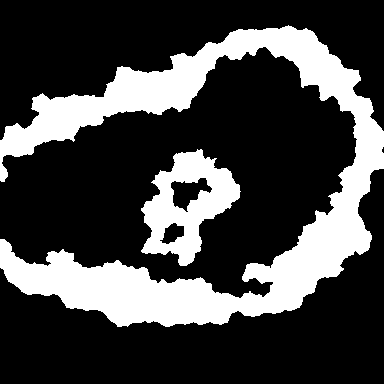

In [93]:
show(arr)

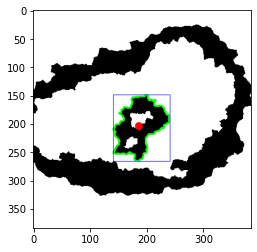

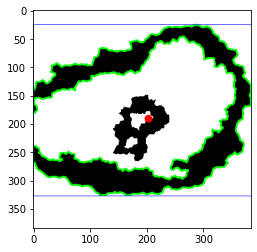

In [97]:
cnts = cv2.findContours(arr.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[1]
for i, c in enumerate(cnts):
    # compute the center of the contour
    M = cv2.moments(c)
    cX = int(M["m10"] / M["m00"])
    cY = int(M["m01"] / M["m00"])
    # draw the contour and center of the shape on the image
    image = 255-arr.copy()
    image = np.stack([image]*3, axis=-1)
    cv2.drawContours(image, [c], -1, (0, 255, 0), 2)
    cv2.circle(image, (cX, cY), 7, (255, 0, 0), -1)
    bbox = cv2.boundingRect(c)
    point1 = (int(bbox[0]), int(bbox[1]))
    point2 = (int(bbox[0]+bbox[2]), int(bbox[1]+bbox[3]))
    cv2.rectangle(image, point1, point2, (0,0,255))
    # cv2.putText(image, "center", (cX - 20, cY - 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)
    # show the image
    Image.fromarray(image).save(f'a{i}.png')
    plt.imshow(image)
    plt.show()